In [1]:
## import os
import sys
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import glob
from astropy.table import Table
from copy import deepcopy

In [2]:
cat = Table.read('jvds_stelkin_cat_v012_mge_v310820_private.fits', hdu=1)
df = cat.to_pandas()

headers_in = ["RE_CIRC_KPC", "MU_AT_RE", "LMSTAR", "SIGMA_RE", "GMINUSI", "MTYPE", "N_SERSIC"]

RE_CIRC_KPC:      FLOAT - Effective Circularised radius in KiloParsec from MGE (F. D'Eugenio in Prep.). \
MU_AT_RE:         FLOAT - Mean surface density at one Re from Bryant et al. 2015 \
LMSTAR:           FLOAT - Log_10 Stellar mass derived from g-i colour from Bryant et al. 2015 and Owers et al. 2017. \ \

GMINUSI:          FLOAT - g-i colour from from Bryant et al. 2015 and Owers et al. 2017. \
MTYPE:            FLOAT - SAMI visual morphological type from Cortese et al. 2016 \
N_SERSIC:         FLOAT - Sersic index from the GAMA best-fit 2D Sersic profile in the r-band Lee et al. 2012 (Concentration)

In [3]:
# Load in our mass radius, mtype and ID data
radius = cat.field('RE_CIRC_KPC')
density = cat.field("MU_AT_RE")
log_mass = cat.field('LMSTAR')
sigma = cat.field("SIGMA_RE")

colour = cat.field("GMINUSI")
mtype = cat.field("MTYPE")
sindex = cat.field("N_SERSIC")

In [4]:
# This is done in order to make the visualisation of the morphological types easier through a colorbar function 

mtype_old = deepcopy(mtype)
for i in range(len(mtype_old)):
    if mtype_old[i] == -9:
        mtype[i] = 6

---

## Lets explore the data and remove any outliers

In [5]:
data_vectors = [radius, density, log_mass, colour, mtype, sindex, sigma]
data_names = ["radius", "density", "log_mass", "colour", "mtype", "sindex", "sigma"]

/usr/local/anaconda3/envs/comp/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/anaconda3/envs/comp/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


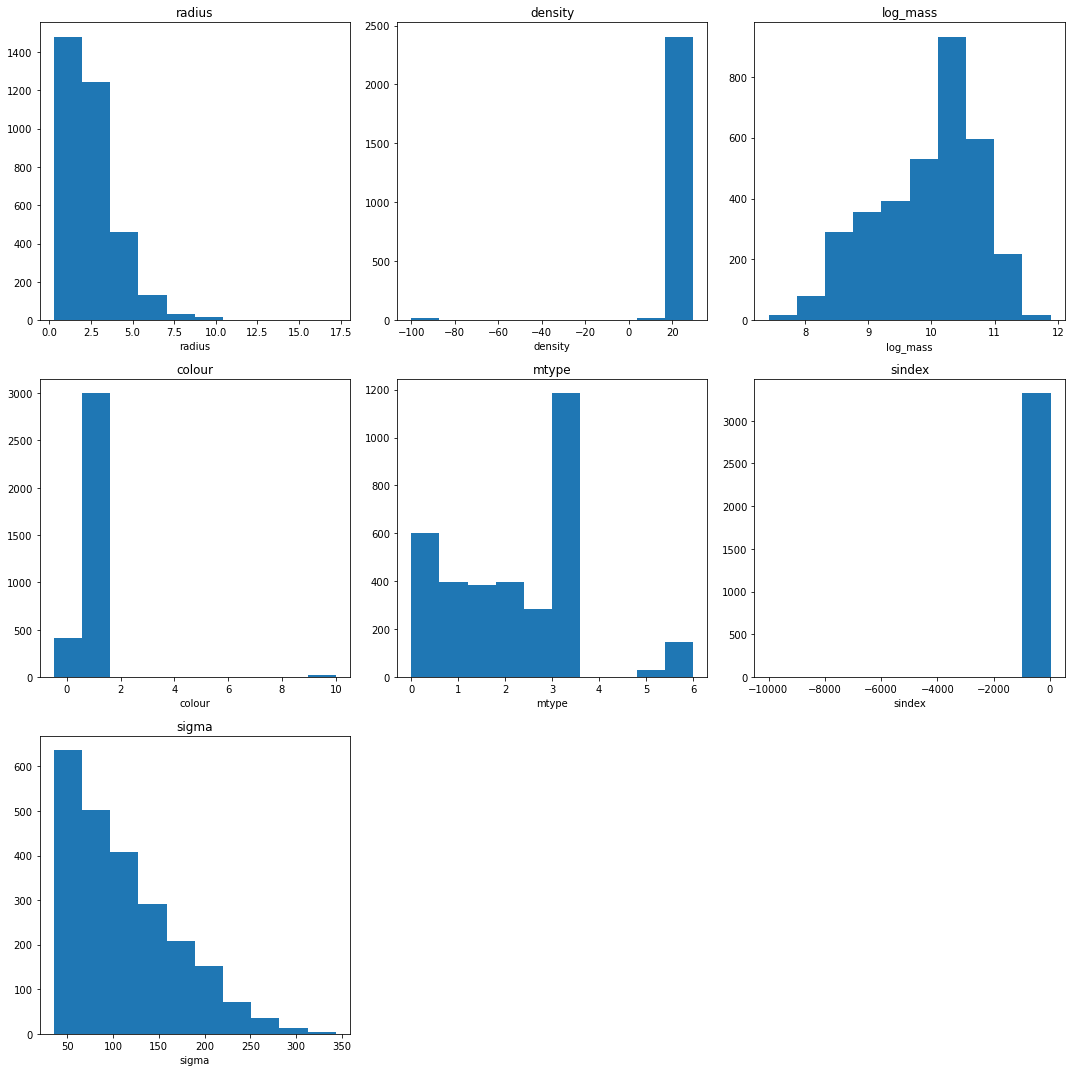

In [6]:
n = len(data_vectors)

plt.figure(figsize=(15, 15))

for i in range(n):
    plt.subplot(3, n//2, i+1)
    plt.hist(data_vectors[i])
    plt.title("{}".format(data_names[i]))
    plt.xlabel(data_names[i])
        
plt.tight_layout()

In [7]:
# Get rid of the crazy outliers, (some crazy sindex one, and the -9 and 5 entires of morphological type)
m1 = sindex > 0
m2 = mtype < 5
m3 = radius <= 10
m4 = (density <= 27.5)*(density >= 18)
m5 = (colour >= 0)*(colour <= 1.5)
m6 = sindex <= 8
# mtrain = mtype <= 1.5
mask_nan = np.logical_not(np.isnan(sigma))

/usr/local/anaconda3/envs/comp/lib/python3.8/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/usr/local/anaconda3/envs/comp/lib/python3.8/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less_equal
  result = getattr(super(), op)(other)
/usr/local/anaconda3/envs/comp/lib/python3.8/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(super(), op)(other)


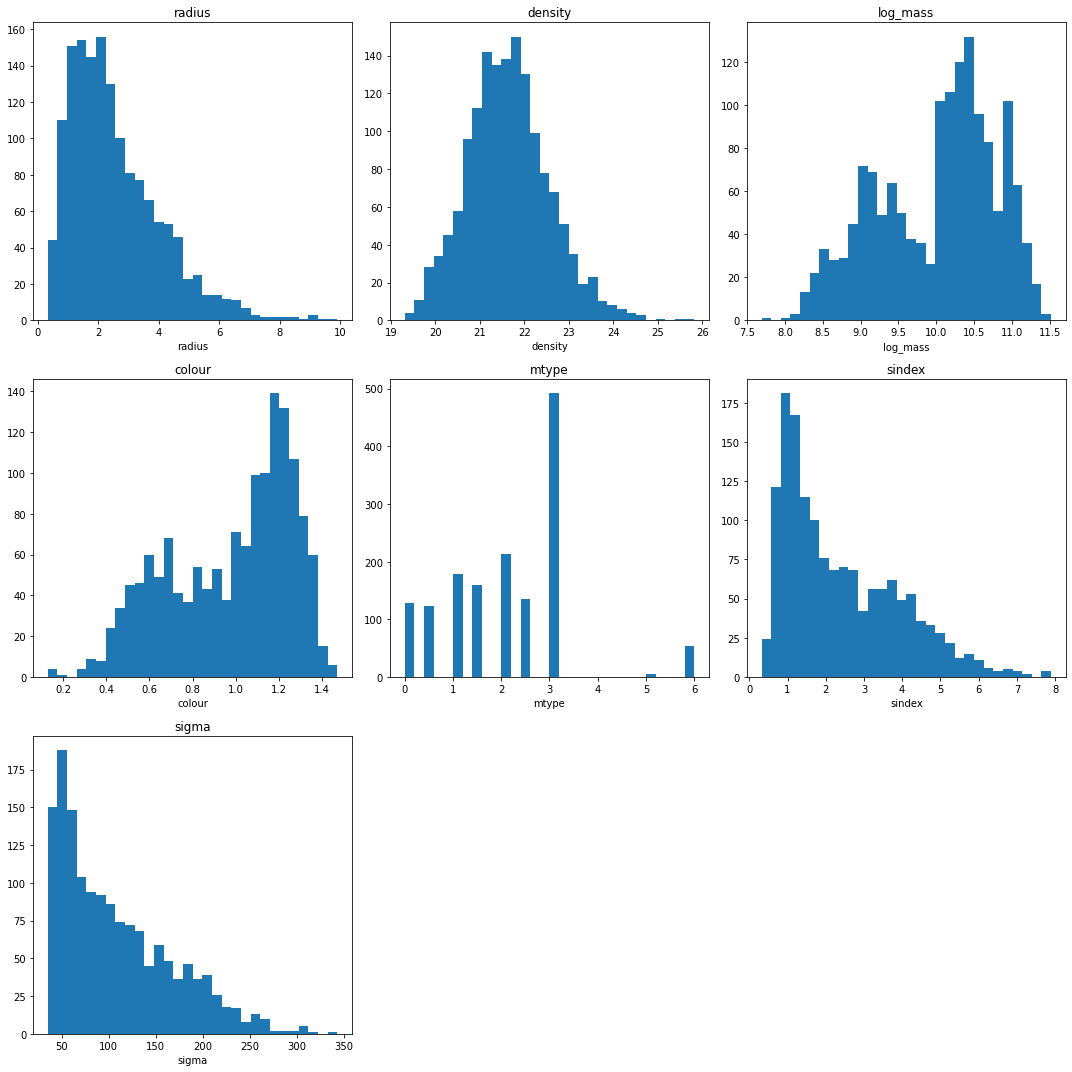

In [8]:
# mask_train = m3*m4*mtrain
mask = m1*m3*m4*m5*m6*mask_nan

n = len(data_vectors)
plt.figure(figsize=(15, 15))

for i in range(n):
    plt.subplot(3, n//2, i+1)
    plt.hist(data_vectors[i][mask], bins=30)
    plt.title("{}".format(data_names[i]))
    plt.xlabel(data_names[i])
        
plt.tight_layout()

---
# Problem 1:
Fundamental plane parameters

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

In [10]:
def FPR(plane_params, data, sum_out=False):
    """
    Sum of squared error with manhatan distance from plane
    plane params should be coefficient1, coefficient2, intercept
    data should be [x, y, z]
    """
    diff = np.abs(plane_params[0]*data[0] + plane_params[1]*data[1] + plane_params[2] - data[2])
    if sum_out:
        return np.sum(diff**2)
    else:
        return diff**2

## We need to use some different masks here since the FP relation only applies to low mtype galaxies

In [11]:
# Only fit plane on low mtype
# nan_mask = mask_train*np.logical_not(np.isnan(sigma))
mask_train = mask*(mtype <= 1.5)
xvals = sigma[mask_train]
yvals = density[mask_train]
zvals = radius[mask_train]
col_val = colour[mask_train]

xvals -= np.median(xvals)
yvals -= np.median(yvals)
zvals -= np.median(zvals)
data = np.array([xvals, yvals, zvals])
print(data.shape)

##############
# All mtypes #
##############
xvals_all = sigma[mask]
yvals_all = density[mask]
zvals_all = radius[mask]
col_val_all = colour[mask]

xvals_all -= np.median(xvals_all)
yvals_all -= np.median(yvals_all)
zvals_all -= np.median(zvals_all)
data_all = np.array([xvals_all, yvals_all, zvals_all])
print(data_all.shape)

(3, 588)
(3, 1490)


In [12]:
lin = LinearRegression(normalize=True).fit(np.array(data[:2]).T, np.array(data[2]))
plane_params = [lin.coef_[0], lin.coef_[1], lin.intercept_]
distances = FPR(plane_params, data_all)

In [13]:
xs = np.linspace(np.min(data[0]), np.max(data[0]))
ys = np.linspace(np.min(data[1]), np.max(data[1]))  
X, Y = np.meshgrid(xs, ys)
Z = lin.coef_[0]*X + lin.coef_[1]*Y + lin.intercept_

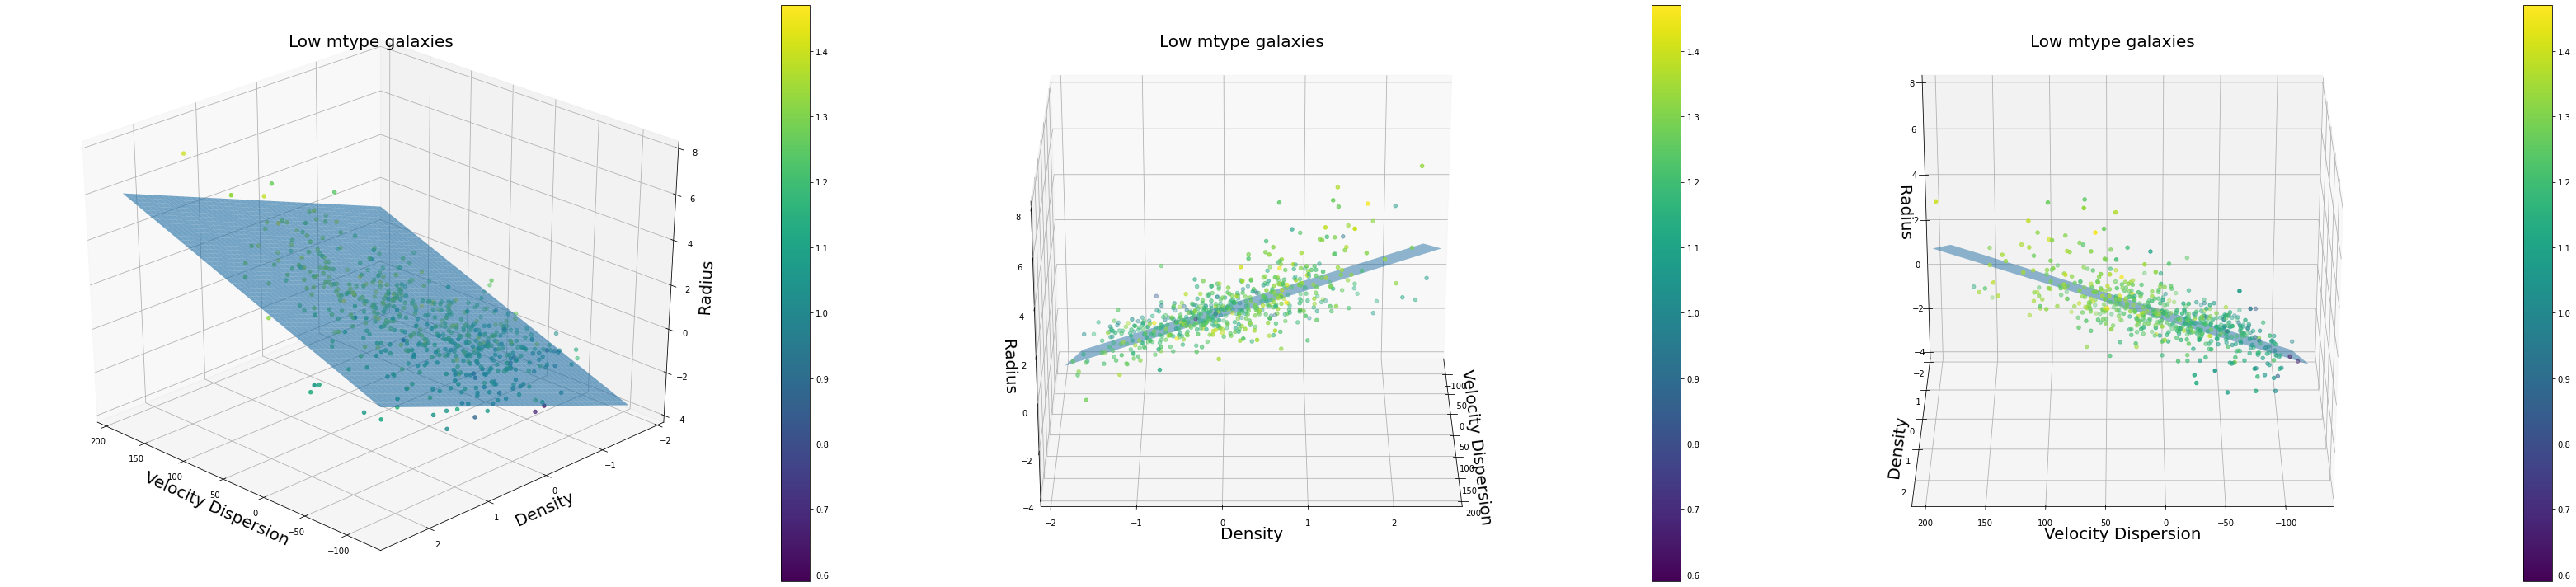

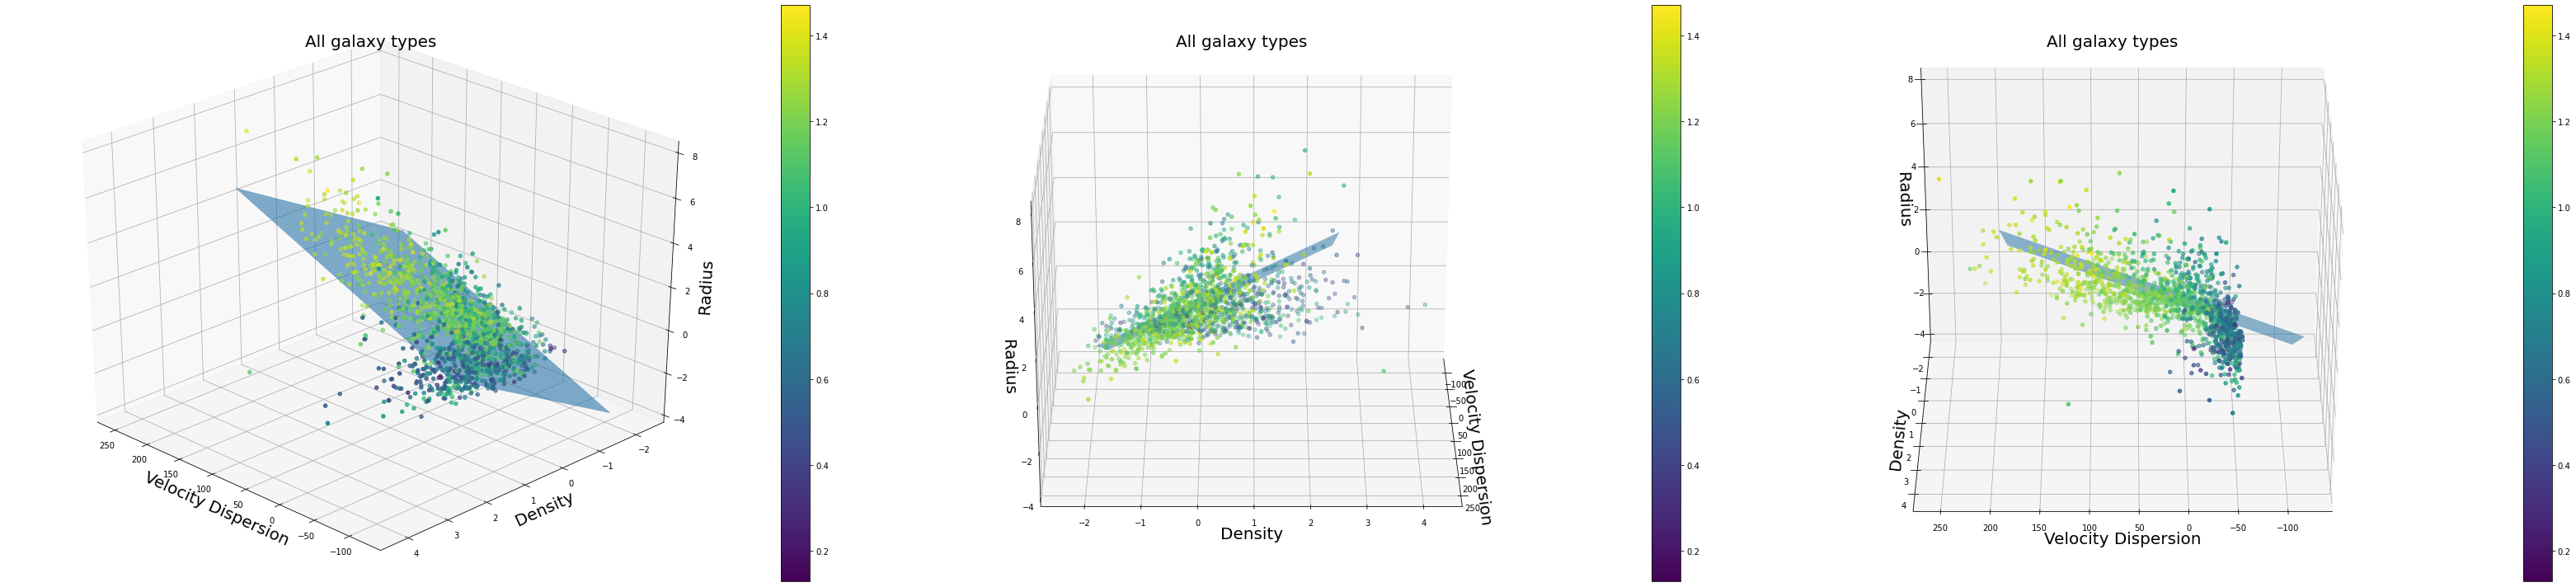

In [14]:
fig = plt.figure(figsize=(45,10))

ax = fig.add_subplot(131, projection='3d')
c = ax.scatter(data[0], data[1], data[2], c=col_val)
ax.plot_surface(X, Y, Z, alpha=0.6)
ax.view_init(30, 135)
plt.colorbar(c)
plt.title("Low mtype galaxies", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.set_xlabel("Velocity Dispersion", fontsize=20)
ax.set_zlabel("Radius", fontsize=20)

ax = fig.add_subplot(132, projection='3d')
c = ax.scatter(data[0], data[1], data[2], c=col_val)
ax.plot_surface(X, Y, Z, alpha=0.6)
ax.view_init(25, 0)
plt.colorbar(c)
plt.title("Low mtype galaxies", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.set_xlabel("Velocity Dispersion", fontsize=20)
ax.set_zlabel("Radius", fontsize=20)

ax = fig.add_subplot(133, projection='3d')
c = ax.scatter(data[0], data[1], data[2], c=col_val)
ax.plot_surface(X, Y, Z, alpha=0.6)
ax.view_init(25, 90)
plt.colorbar(c)
plt.title("Low mtype galaxies", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.set_xlabel("Velocity Dispersion", fontsize=20)
ax.set_zlabel("Radius", fontsize=20)

plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(45,10))

ax = fig.add_subplot(131, projection='3d')
c = ax.scatter(data_all[0], data_all[1], data_all[2], c=col_val_all)
ax.plot_surface(X, Y, Z, alpha=0.6)
ax.view_init(30, 135)
plt.colorbar(c)
plt.title("All galaxy types", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.set_xlabel("Velocity Dispersion", fontsize=20)
ax.set_zlabel("Radius", fontsize=20)

ax = fig.add_subplot(132, projection='3d')
c = ax.scatter(data_all[0], data_all[1], data_all[2], c=col_val_all)
ax.plot_surface(X, Y, Z, alpha=0.6)
ax.view_init(25, 0)
plt.colorbar(c)
plt.title("All galaxy types", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.set_xlabel("Velocity Dispersion", fontsize=20)
ax.set_zlabel("Radius", fontsize=20)

ax = fig.add_subplot(133, projection='3d')
c = ax.scatter(data_all[0], data_all[1], data_all[2], c=col_val_all)
ax.plot_surface(X, Y, Z, alpha=0.6)
ax.view_init(30, 90)
plt.colorbar(c)
plt.title("All galaxy types", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.set_xlabel("Velocity Dispersion", fontsize=20)
ax.set_zlabel("Radius", fontsize=20)

plt.tight_layout()

---
# Problem 2:
Can the FP relation predict the other values?

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [18]:
RMSE = lambda predictor, X, Y :np.sqrt(mean_squared_error(Y, tree.predict(X)))

In [19]:
X_names = ["Radius", "Sigma", "Density", "Distance"]
X_data_raw = np.array([radius[mask], sigma[mask], density[mask], distances]).T

Y_names = ["Log Mass", "Mtype", "Colour", "S index"]
Y_data_raw = np.array([log_mass[mask], mtype[mask], colour[mask], sindex[mask]]).T

# Create the holdout data, keep random state of zero
X_data, X_data_holdout, Y_data, Y_data_holdout = train_test_split(X_data_raw, Y_data_raw, test_size=0.3, random_state=0)
Y_data, Y_data_holdout = list(Y_data.T), list(Y_data_holdout.T)

In [21]:
Ntest = 5
params = {
    'max_depth': np.arange(5, 15),
    'splitter': ["best", "random"]
        }

best_DTs = []
for i in range(len(Y_data)):
    depths = []
    splitters = []
    for r in range(Ntest):
        X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data[i], test_size=0.25, random_state=r)
        cv = GridSearchCV(DecisionTreeRegressor(), params).fit(X_train, Y_train)
        depths.append(cv.best_params_['max_depth'])
        splitters.append(cv.best_params_['splitter'])

    best_depth = np.round(np.average(depths), decimals=0).astype(np.int16)
    best_splitter = max(set(splitters), key=splitters.count)
    best_DTs.append(DecisionTreeRegressor(max_depth=best_depth, splitter=best_splitter))
    print(best_depth, best_splitter)

9 random
6 random
6 random
7 random


In [26]:
%%time
Ntest = 5
params = {
    'n_estimators': np.arange(10, 20, 2),
    'bootstrap': [True, False]
        }

best_BGs = []
for i in range(len(Y_data)):
    n_ests = []
    bootstraps = []
    for r in range(Ntest):
        X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data[i], test_size=0.25, random_state=r)
        cv = GridSearchCV(BaggingRegressor(), params).fit(X_train, Y_train)
        n_ests.append(cv.best_params_['n_estimators'])
        bootstraps.append(cv.best_params_['bootstrap'])

    best_n_est = np.round(np.average(n_ests), decimals=0).astype(np.int16)
    best_bootstrap = max(set(bootstraps), key=bootstraps.count)
    best_BGs.append(BaggingRegressor(n_estimators=best_n_est, bootstrap=best_bootstrap))
    print(best_n_est, best_bootstrap)

16 True
16 True
16 True
16 True
CPU times: user 38.1 s, sys: 596 ms, total: 38.7 s
Wall time: 39.7 s


In [28]:
%%time
Ntest = 3
params = {
    'n_estimators': np.arange(50, 200, 25),
    'max_depth': np.arange(5, 21, 3)
        }

best_RFs = []
for i in range(len(Y_data)):
    n_ests = []
    depths = []
    for r in range(Ntest):
        X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data[i], test_size=0.25, random_state=r)
        cv = GridSearchCV(RandomForestRegressor(), params).fit(X_train, Y_train)
        n_ests.append(cv.best_params_['n_estimators'])
        depths.append(cv.best_params_['max_depth'])

    best_n_est = np.round(np.average(n_ests), decimals=0).astype(np.int16)
    best_depth = np.round(np.average(depths), decimals=0).astype(np.int16)
    best_RFs.append(RandomForestRegressor(n_estimators=best_n_est, max_depth=best_depth))
    print(best_n_est, best_depth)

158 9
100 5
100 5
83 14
CPU times: user 7min 30s, sys: 9.29 s, total: 7min 39s
Wall time: 7min 56s


In [29]:
predictors = [best_DTs, best_BGs, best_RFs]
pred_names = ["DT", "BG", "RF"]
cols = ['tab:blue', 'tab:orange', 'tab:green']

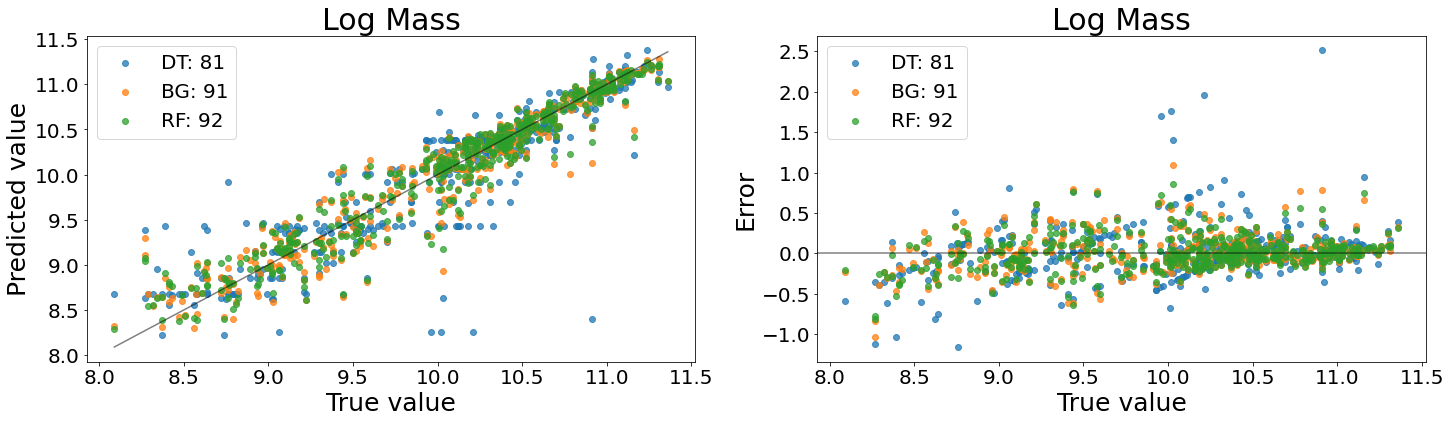

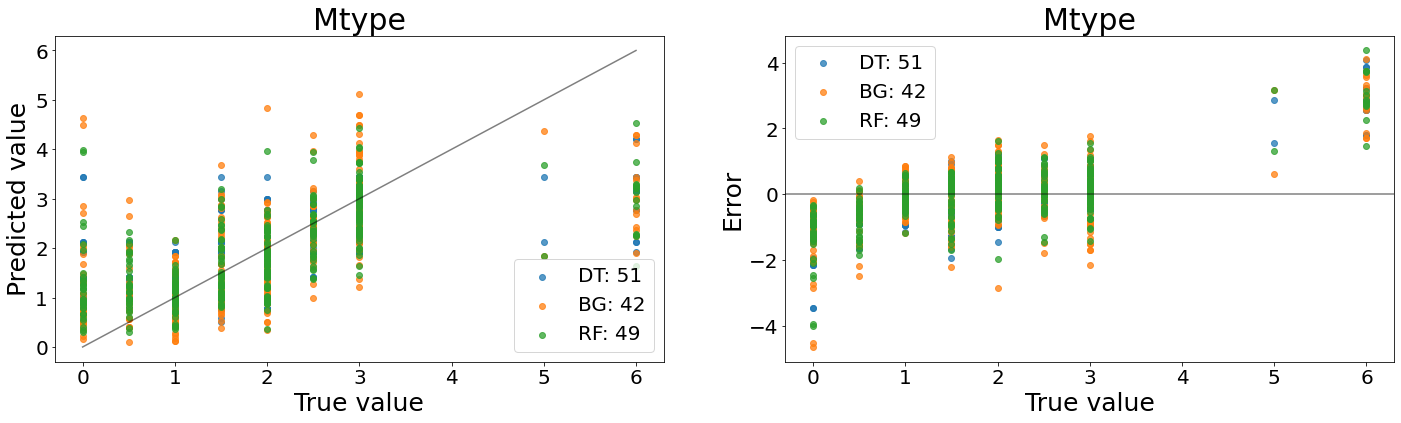

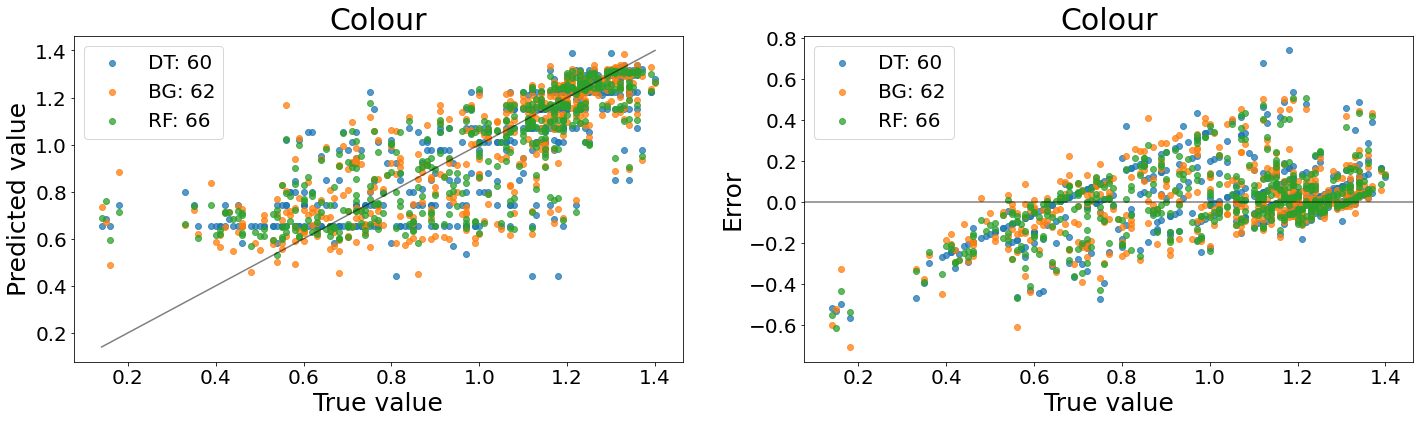

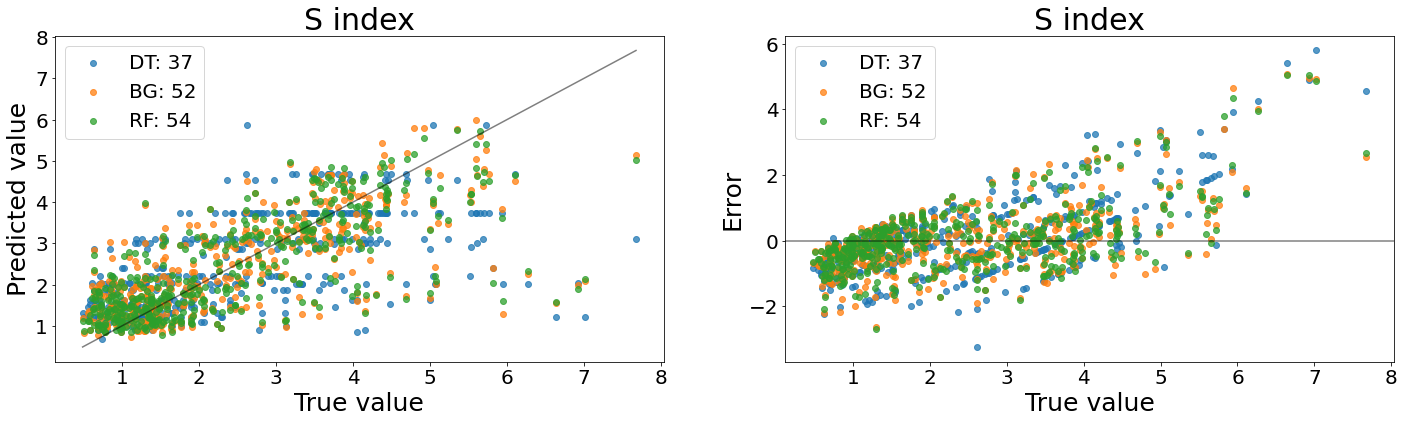

In [32]:
for i in range(len(Y_data)):
    plt.figure(figsize=(24, 6))
    trained = []
    for j in range(len(predictors)):
        trained.append(predictors[j][i].fit(X_data, Y_data[i]))
        
    plt.subplot(1, 2, 1)
    for j in range(len(predictors)):
        Rsq = 100*r2_score(Y_data_holdout[i], trained[j].predict(X_data_holdout))
        plt.scatter(Y_data_holdout[i], trained[j].predict(X_data_holdout), c=cols[j], label="{}: {:.0f}".format(pred_names[j], Rsq), alpha=0.75) 
    xs = np.linspace(np.min(Y_data_holdout[i]), np.max(Y_data_holdout[i]))
    plt.plot(xs, xs, alpha=0.5, c='k')
    plt.legend(fontsize=20)
    plt.title(Y_names[i], fontsize=30)
    plt.xlabel("True value", fontsize=25)
    plt.ylabel("Predicted value", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.subplot(1, 2, 2)
    for j in range(len(predictors)):
        Rsq = 100*r2_score(Y_data_holdout[i], trained[j].predict(X_data_holdout))
        plt.scatter(Y_data_holdout[i], Y_data_holdout[i] - trained[j].predict(X_data_holdout), c=cols[j], label="{}: {:.0f}".format(pred_names[j], Rsq), alpha=0.75) 
        
    plt.axhline(0, c='k', alpha=0.5)
    plt.legend(fontsize=20)
    plt.title(Y_names[i], fontsize=30)
    plt.xlabel("True value", fontsize=25)
    plt.ylabel("Error", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.savefig("test {}".format(i))

---
# Problem 3:
How related are each of the parameters? Show weightings and predictability of each one

In [39]:
names = ["Radius", "Sigma", "Density", "Distance", "Log Mass", "Mtype", "Colour", "S index"]
cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:pink', 'tab:cyan', 'tab:olive']
data_raw = np.array([radius[mask], sigma[mask], density[mask], distances, log_mass[mask], mtype[mask], colour[mask], sindex[mask]]).T

# Create the holdout data, keep random state of zero
data, data_holdout = train_test_split(data_raw, test_size=0.3, random_state=0)
data, data_holdout = list(data.T), list(data_holdout.T)

In [43]:
Ntest = 5
params = {
    'max_depth': np.arange(5, 15),
    'splitter': ["best", "random"]
        }

best_DTs = []
for i in range(len(data)):
    # Construct data so its formatted approriately
    Y_data = data[i]
    X_data = np.array(data[:i] + data[i+1:]).T

    n_ests = []
    bootstraps = []
    for r in range(Ntest):
        X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.25, random_state=r)
        cv = GridSearchCV(DecisionTreeRegressor(), params).fit(X_train, Y_train)
        depths.append(cv.best_params_['max_depth'])
        splitters.append(cv.best_params_['splitter'])

    best_depth = np.round(np.average(depths), decimals=0).astype(np.int16)
    best_splitter = max(set(splitters), key=splitters.count)
    best_DTs.append(DecisionTreeRegressor(max_depth=best_depth, splitter=best_splitter))
    print(best_depth, best_splitter)

8 best
8 best
8 best
8 best
9 best
8 best
8 best
8 best


In [45]:
%%time
Ntest = 5
params = {
    'n_estimators': np.arange(10, 20, 2),
    'bootstrap': [True, False]
        }

best_BGs = []
for i in range(len(data)):
    Y_data = data[i]
    X_data = np.array(data[:i] + data[i+1:]).T

    n_ests = []
    bootstraps = []
    for r in range(Ntest):
        X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.25, random_state=r)
        cv = GridSearchCV(BaggingRegressor(), params).fit(X_train, Y_train)
        n_ests.append(cv.best_params_['n_estimators'])
        bootstraps.append(cv.best_params_['bootstrap'])

    best_n_est = np.round(np.average(n_ests), decimals=0).astype(np.int16)
    best_bootstrap = max(set(bootstraps), key=bootstraps.count)
    best_BGs.append(BaggingRegressor(n_estimators=best_n_est, bootstrap=best_bootstrap))
    print(best_n_est, best_bootstrap)

17 True
14 True
15 True
14 True
15 True
14 True
16 True
15 True
CPU times: user 1min 40s, sys: 1.72 s, total: 1min 42s
Wall time: 1min 48s


In [75]:
%%time
Ntest = 3
params = {
    'n_estimators': np.arange(75, 150, 25),
    'max_depth': np.arange(5, 18, 3)
        }

best_RFs = []
for i in range(len(data)):
    Y_data = data[i]
    X_data = np.array(data[:i] + data[i+1:]).T
    n_ests = []
    depths = []
    for r in range(Ntest):
        X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.25, random_state=r)
        cv = GridSearchCV(RandomForestRegressor(), params).fit(X_train, Y_train)
        n_ests.append(cv.best_params_['n_estimators'])
        depths.append(cv.best_params_['max_depth'])

    best_n_est = np.round(np.average(n_ests), decimals=0).astype(np.int16)
    best_depth = np.round(np.average(depths), decimals=0).astype(np.int16)
    best_RFs.append(RandomForestRegressor(n_estimators=best_n_est, max_depth=best_depth))
    print(best_n_est, best_depth)

125 15
100 13
133 16
133 15
117 16
117 5
117 12
125 16
CPU times: user 18min 39s, sys: 19.8 s, total: 18min 59s
Wall time: 19min 45s


In [77]:
classifiers = [best_DTs, best_RFs]
classifier_names = ["DT", "RF"]

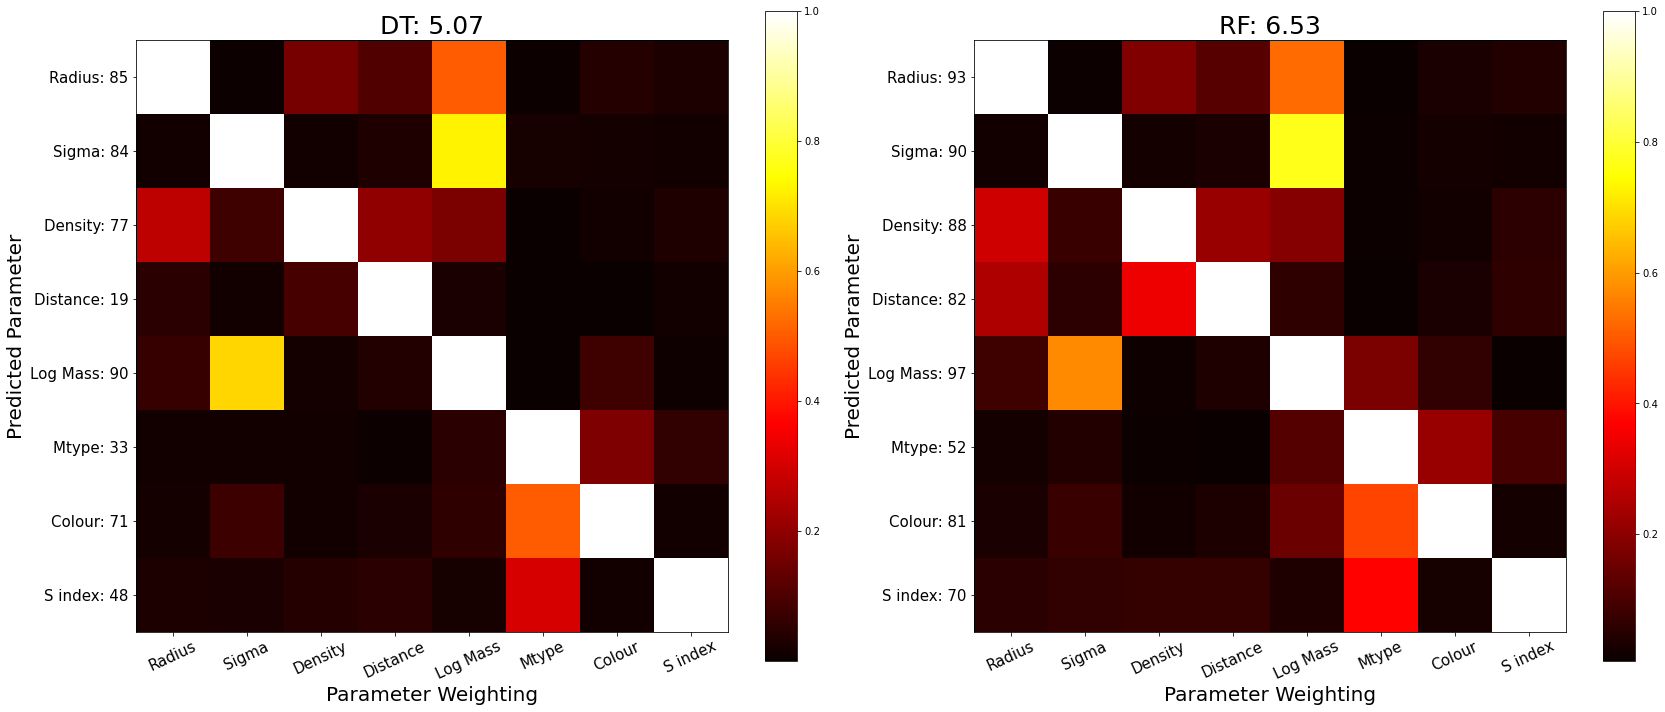

In [116]:
plt.figure(figsize=(24, 10))

for j in range(len(classifiers)):
    squares = np.ones([len(names), len(names)])
    name_weights = []    
    for i in range(len(data)):
        Y_data = data[i]
        X_data = np.array(data[:i] + data[i+1:]).T
        Y_data_holdout = data_holdout[i]
        X_data_holdout = np.array(data_holdout[:i] + data_holdout[i+1:]).T
        Y_name = names[i]
        X_names = names[:i] + names[i+1:]

        # Make classifer
        classifier = classifiers[j][i].fit(X_data, Y_data)
        Rsq = r2_score(Y_data_holdout, classifier.predict(X_data_holdout))
        weights = Rsq*classifier.feature_importances_
        name_weights.append("{}: {:.0f}".format(Y_name, 100*Rsq))

        # Generate correlations
        squares[i, :i] = weights[:i]
        squares[i, i+1:] = weights[i:]
        
#         # Print values for checking
#         print("{}:   {:.2f}".format(Y_name, Rsq))
#         for k in range(len(X_names)):
#             print("    {}:\t{:.2f}".format(X_names[k], classifier.feature_importances_[k]))
#         print('\n')
        

    plt.subplot(1, 2, j+1)
    plt.imshow(squares, cmap='hot')
    plt.xticks(np.arange(len(names)), names, fontsize=15, rotation=25)
    plt.yticks(np.arange(len(names)), name_weights, fontsize=15)
    plt.title("{}: {:.2f}".format(classifier_names[j], np.sum(squares)-8), fontsize=25)
    plt.ylabel("Predicted Parameter", fontsize=20)
    plt.xlabel("Parameter Weighting", fontsize=20)
    plt.colorbar()
plt.tight_layout()
plt.savefig("Best Fig")
plt.show()

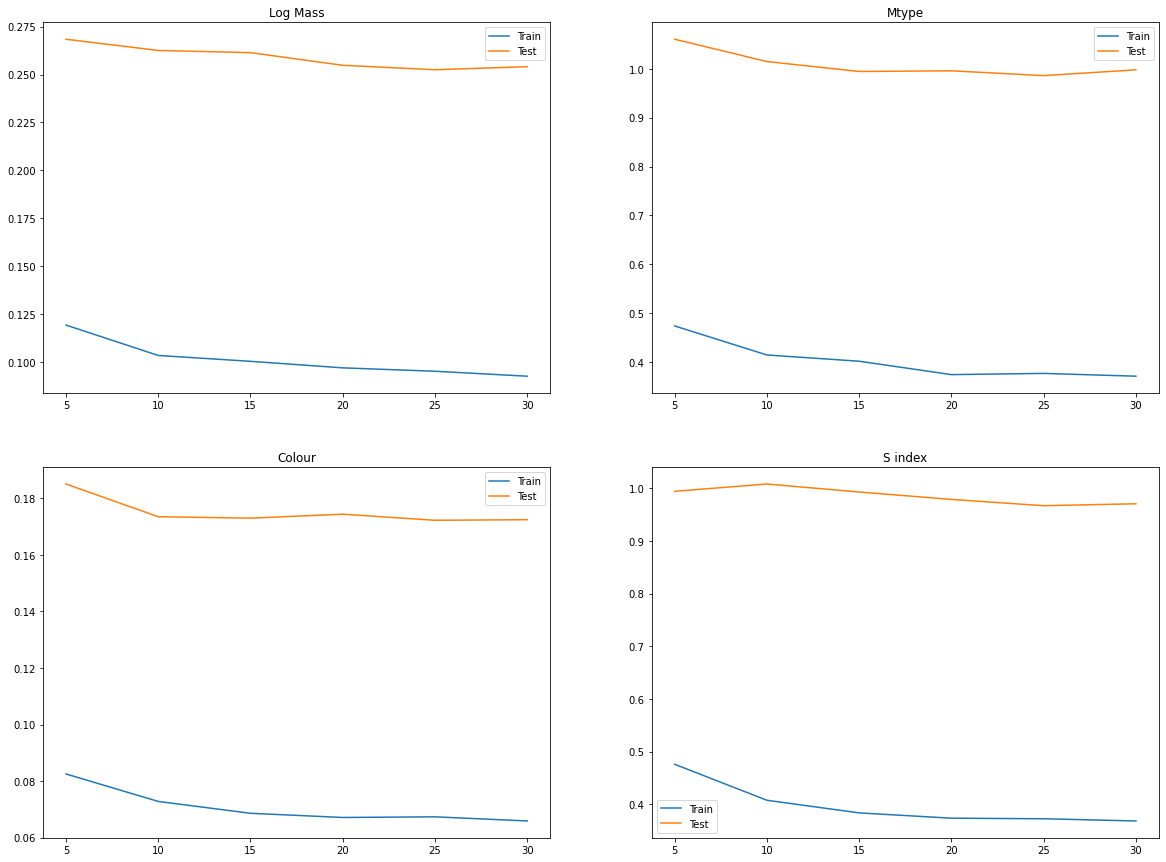

In [194]:
n_est = np.arange(5, 35, 5)
Ntest = 5

train_errs = np.zeros([len(Y_data), len(depths)])
test_errs = np.zeros([len(Y_data), len(depths)])

for i in range(len(Y_data)):
    for j in range(len(depths)):
        for r in range(Ntest):
            X_train, X_test, Y_train, Y_test = train_test_split(np.array(X_data).T, Y_data[i], test_size=0.25, random_state=r)
            tree = BaggingRegressor(n_estimators=n_est[j]).fit(X_train, Y_train)
            train_errs[i, j] += RMSE(tree, X_train, Y_train)/Ntest
            test_errs[i, j] += RMSE(tree, X_test, Y_test)/Ntest


plt.figure(figsize=(20, 15))
for i in range(len(Y_data)):
    plt.subplot(2, 2, i+1)
    plt.plot(depths, train_errs[i], label="Train")
    plt.plot(depths, test_errs[i], label="Test")
    plt.title(Y_names[i])
    plt.legend()
plt.show()

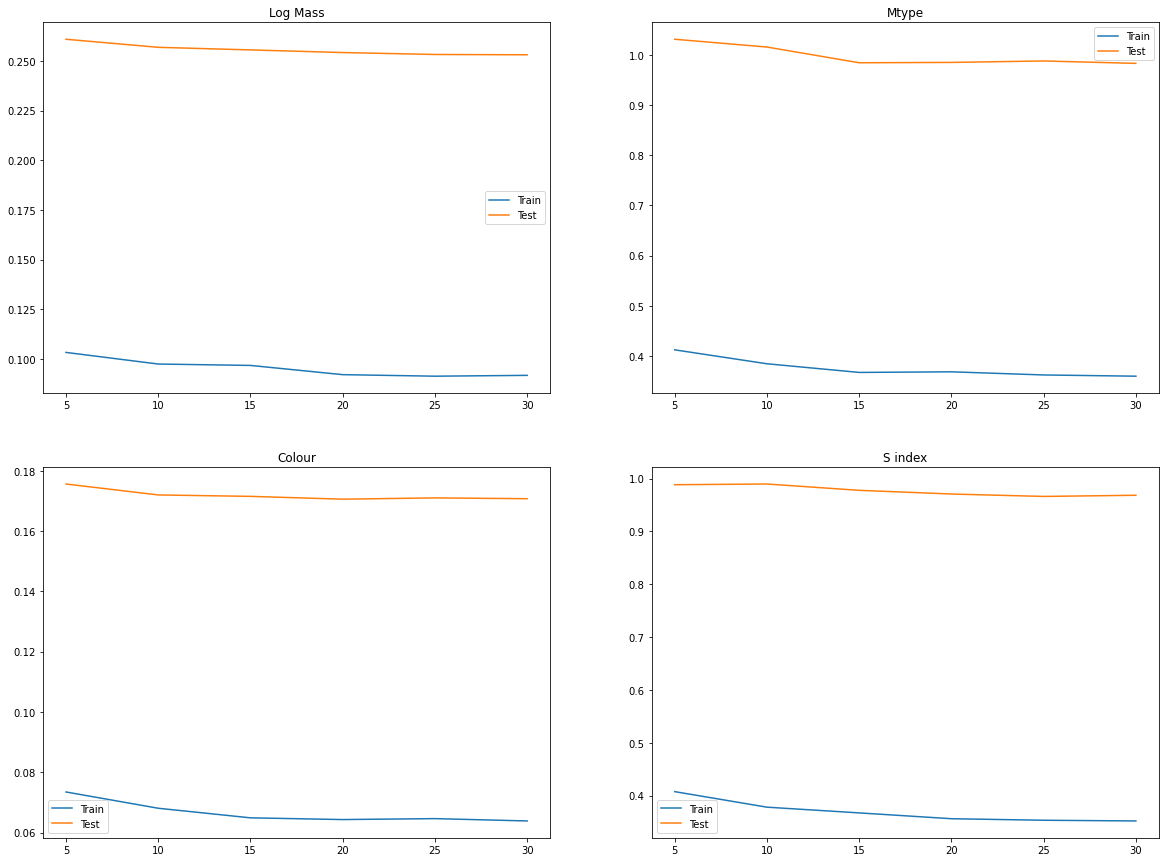

In [196]:
n_est = np.arange(10, 110, 10)
Ntest = 5

train_errs = np.zeros([len(Y_data), len(depths)])
test_errs = np.zeros([len(Y_data), len(depths)])

for i in range(len(Y_data)):
    for j in range(len(depths)):
        for r in range(Ntest):
            X_train, X_test, Y_train, Y_test = train_test_split(np.array(X_data).T, Y_data[i], test_size=0.25, random_state=r)
            tree = RandomForestRegressor(n_estimators=n_est[j]).fit(X_train, Y_train)
            train_errs[i, j] += RMSE(tree, X_train, Y_train)/Ntest
            test_errs[i, j] += RMSE(tree, X_test, Y_test)/Ntest


plt.figure(figsize=(20, 15))
for i in range(len(Y_data)):
    plt.subplot(2, 2, i+1)
    plt.plot(depths, train_errs[i], label="Train")
    plt.plot(depths, test_errs[i], label="Test")
    plt.title(Y_names[i])
    plt.legend()
plt.show()

---

## See how well each parameter can be used to predict Radius, Density and Mass

In [188]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, mean_squared_error, r2_score

In [108]:
cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:pink', 'tab:cyan', 'tab:olive']
names = ["Radius", "Density", "Log Mass", "Mtype", "Colour", "S index", "Sigma"]
data_raw = np.array([radius[mask], density[mask], log_mass[mask], mtype[mask], colour[mask], sindex[mask], sigma[mask]]).T

# Create the holdout data, keep random state of zero
data, data_holdout = train_test_split(data_raw, test_size=0.3, random_state=0)
data, data_holdout = list(data.T), list(data_holdout.T)

predict_idx = [0, 1, 2]

In [109]:
depths = np.arange(5, 35, 5)
Ntest = 5

train_vals_all = []
test_vals_all = []
feature_vals_all = []
for i in predict_idx:
    target = data[i]
    name = names[i]
    names_in = names[:i] + names[i+1:]
    data_in = np.array(data[:i] + data[i+1:]).T
    test_errs = np.zeros(depths.shape)
    train_errs = np.zeros(depths.shape)
    feature_vals = np.zeros([len(depths), len(names_in)])
    
    for j in range(len(depths)):
            for k in range(Ntest):
                X_train, X_test, Y_train, Y_test = train_test_split(data_in, target, test_size=0.25, random_state=k)
#                 tree = DecisionTreeRegressor(max_depth=depths[j]).fit(X_train, Y_train)
                tree = RandomForestRegressor(max_depth=depths[j]).fit(X_train, Y_train)
                test_errs[j] += np.sqrt(mean_squared_error(Y_test, tree.predict(X_test)))/Ntest
                train_errs[j] += np.sqrt(mean_squared_error(Y_train, tree.predict(X_train)))/Ntest
                feature_vals[j] += (tree.feature_importances_*100)/Ntest
    feature_vals_all.append(feature_vals.T)
    train_vals_all.append(train_errs)
    test_vals_all.append(test_errs)

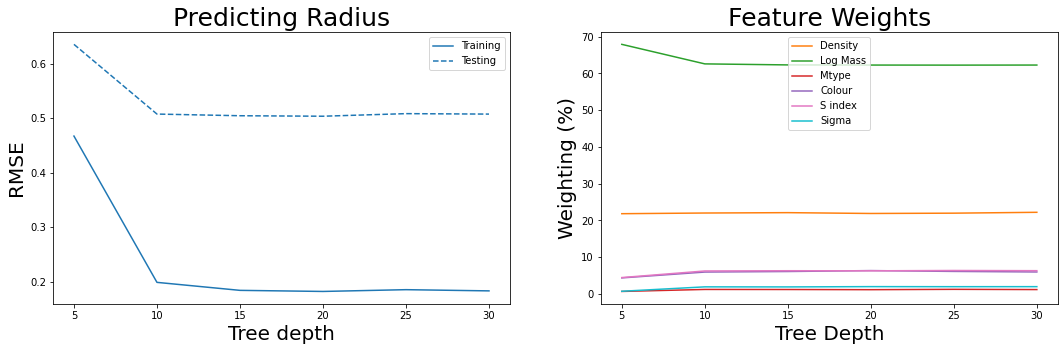

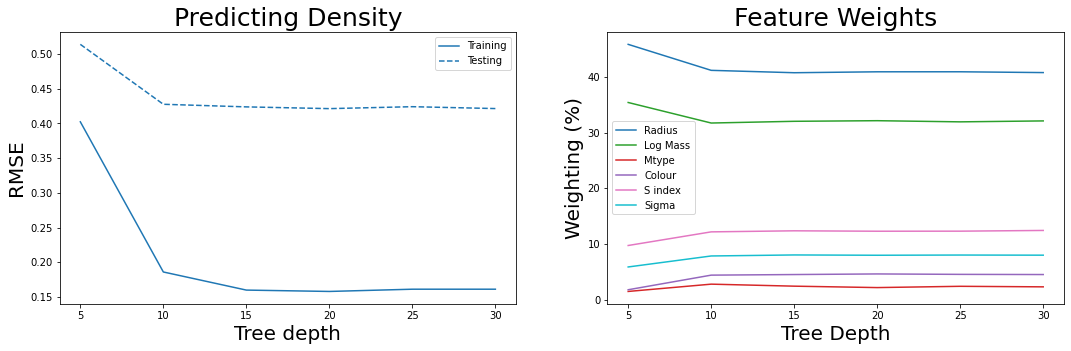

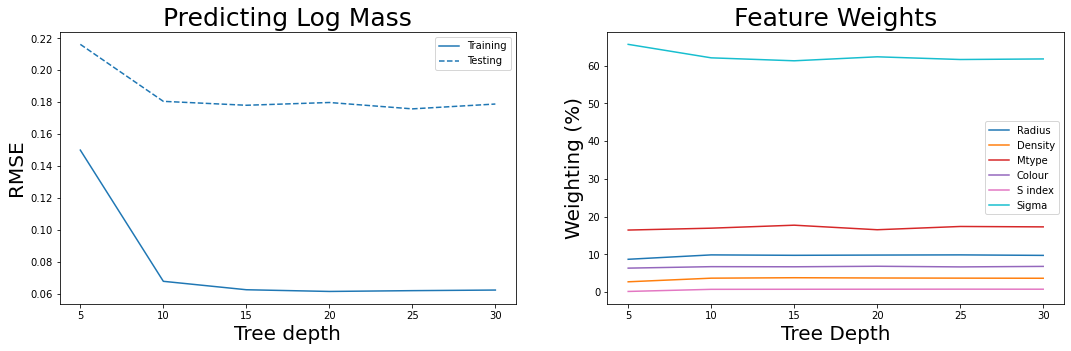

In [110]:
for i in predict_idx:
    cols_in = cols[:i] + cols[i+1:]
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 2, 1)
    plt.plot(depths, train_vals_all[i], label='Training', c='tab:blue')
    plt.plot(depths, test_vals_all[i], label='Testing', c='tab:blue', linestyle='--')
    plt.title("Predicting {}".format(names[i]), fontsize=25)
    plt.ylabel("RMSE", fontsize=20)
    plt.xlabel("Tree depth", fontsize=20)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    name = names[i]
    names_in = names[:i] + names[i+1:]
    for j in range(len(feature_vals_all[i])):
        plt.plot(depths, feature_vals_all[i][j], label=names_in[j], c=cols_in[j])
    plt.title("Feature Weights", fontsize=25)
    plt.ylabel("Weighting (%)", fontsize=20)
    plt.xlabel("Tree Depth", fontsize=20)
    plt.legend()

    plt.show()

---

### S index and Colour are not very usefull so we will remove them and see if it changes the results

In [124]:
# cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
# names = ["Radius", "Density", "Log Mass", "Mtype"]
# data_raw = np.array([radius[mask], density[mask], log_mass[mask], mtype[mask]]).T

# # Create the holdout data, keep random state of zero
# data, data_holdout = train_test_split(data_raw, test_size=0.3, random_state=0)
# data, data_holdout = list(data.T), list(data_holdout.T)

# predict_idx = [0, 1, 2]

# cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:pink', 'tab:cyan']
# names = ["Radius", "Density", "Log Mass", "Mtype", "Colour", "S index"]
# data_raw = np.array([radius[mask], density[mask], log_mass[mask], mtype[mask], colour[mask], sindex[mask]]).T

# # Create the holdout data, keep random state of zero
# data, data_holdout = train_test_split(data_raw, test_size=0.3, random_state=0)
# data, data_holdout = list(data.T), list(data_holdout.T)

# predict_idx = [0, 1, 2]


names = ["Radius", "Density", "Log Mass"]
data_raw = np.array([radius[mask], density[mask], log_mass[mask], mtype[mask], sigma[mask]]).T

# Create the holdout data, keep random state of zero
data, data_holdout = train_test_split(data_raw, test_size=0.3, random_state=0)
data, data_holdout = list(data.T), list(data_holdout.T)

predict_idx = [0, 1, 2]

In [125]:
depths = np.arange(5, 35, 5)
Ntest = 5

train_vals_small = []
test_vals_small = []
feature_vals_small = []
for i in predict_idx:
    target = data[i]
#     name = names[i]
#     names_in = names[:i] + names[i+1:]
    data_in = np.array(data[:i] + data[i+1:]).T
    test_errs = np.zeros(depths.shape)
    train_errs = np.zeros(depths.shape)
#     feature_vals = np.zeros([len(depths), len(names_in)])
    
    for j in range(len(depths)):
            for k in range(Ntest):
                X_train, X_test, Y_train, Y_test = train_test_split(data_in, target, test_size=0.25, random_state=k)
#                 tree = DecisionTreeRegressor(max_depth=depths[j]).fit(X_train, Y_train)
                tree = RandomForestRegressor(max_depth=depths[j]).fit(X_train, Y_train)
                test_errs[j] += np.sqrt(mean_squared_error(Y_test, tree.predict(X_test)))/Ntest
                train_errs[j] += np.sqrt(mean_squared_error(Y_train, tree.predict(X_train)))/Ntest
#                 feature_vals[j] += (tree.feature_importances_*100)/Ntest
#     feature_vals_small.append(feature_vals.T)
    train_vals_small.append(train_errs)
    test_vals_small.append(test_errs)

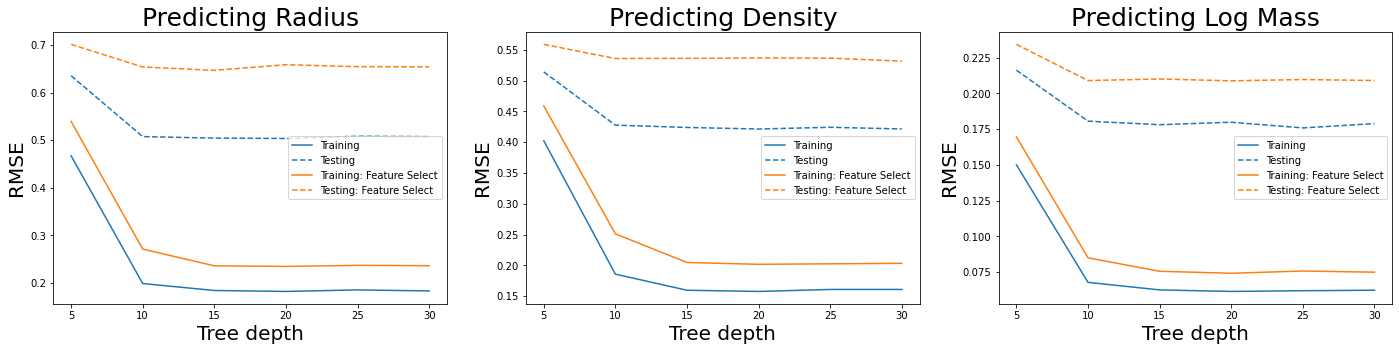

In [126]:
plt.figure(figsize=(24, 5))
for i in predict_idx:
    cols_in = cols[:i] + cols[i+1:]
    plt.subplot(1, 3, i+1)
    plt.plot(depths, train_vals_all[i], label='Training', c='tab:blue')
    plt.plot(depths, test_vals_all[i], label='Testing', c='tab:blue', linestyle='--')
    plt.plot(depths, train_vals_small[i], label='Training: Feature Select', c='tab:orange')
    plt.plot(depths, test_vals_small[i], label='Testing: Feature Select', c='tab:orange', linestyle='--')
    plt.title("Predicting {}".format(names[i]), fontsize=25)
    plt.ylabel("RMSE", fontsize=20)
    plt.xlabel("Tree depth", fontsize=20)
    plt.legend()
plt.show()

# This makes the results a bit worse, but not much was able to be learned anyway
---
## Now we try and improve the prediction by using distance from FP to as a new parameter

---

# Now lets try again with distance as a new paramter

In [127]:
names = ["Radius", "Density", "Log Mass"]
data_raw = np.array([radius[mask], density[mask], log_mass[mask], mtype[mask], distances]).T

# Create the holdout data, keep random state of zero
data, data_holdout = train_test_split(data_raw, test_size=0.3, random_state=0)
data, data_holdout = list(data.T), list(data_holdout.T)

predict_idx = [0, 1, 2]


# names = ["Radius", "Density", "Log Mass"]
# data_raw = np.array([radius[mask], density[mask], log_mass[mask], mtype[mask], colour[mask], sindex[mask], sigma[mask], distances]).T

# # Create the holdout data, keep random state of zero
# data, data_holdout = train_test_split(data_raw, test_size=0.3, random_state=0)
# data, data_holdout = list(data.T), list(data_holdout.T)

# predict_idx = [0, 1, 2]

In [128]:
depths = np.arange(5, 35, 5)
Ntest = 5

train_vals_dist = []
test_vals_dist = []
for i in predict_idx:
    target = data[i]
    data_in = np.array(data[:i] + data[i+1:]).T
    test_errs = np.zeros(depths.shape)
    train_errs = np.zeros(depths.shape)
    
    for j in range(len(depths)):
            for k in range(Ntest):
                X_train, X_test, Y_train, Y_test = train_test_split(data_in, target, test_size=0.25, random_state=k)
#                 tree = DecisionTreeRegressor(max_depth=depths[j]).fit(X_train, Y_train)
                tree = RandomForestRegressor(max_depth=depths[j]).fit(X_train, Y_train)
                test_errs[j] += np.sqrt(mean_squared_error(Y_test, tree.predict(X_test)))/Ntest
                train_errs[j] += np.sqrt(mean_squared_error(Y_train, tree.predict(X_train)))/Ntest
    train_vals_dist.append(train_errs)
    test_vals_dist.append(test_errs)

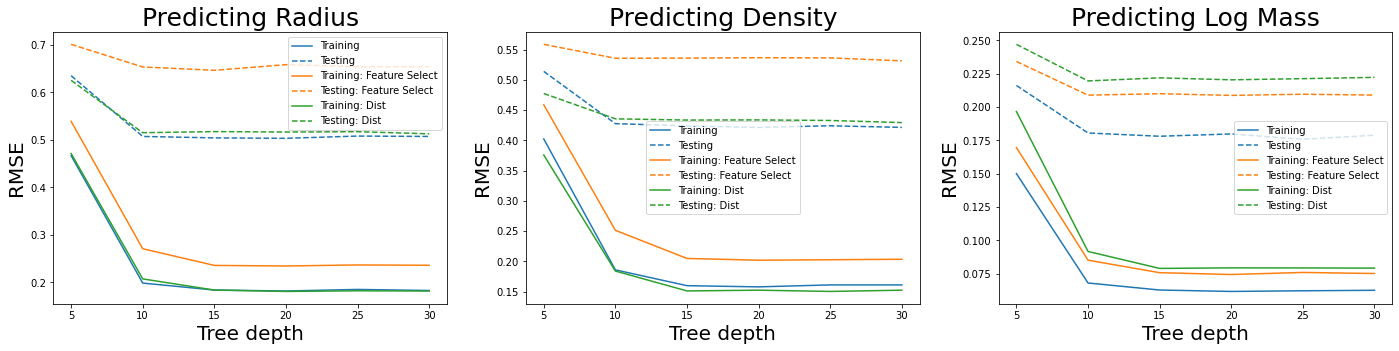

In [129]:
plt.figure(figsize=(24, 5))
for i in predict_idx:
    cols_in = cols[:i] + cols[i+1:]
    plt.subplot(1, 3, i+1)
    plt.plot(depths, train_vals_all[i], label='Training', c='tab:blue')
    plt.plot(depths, test_vals_all[i], label='Testing', c='tab:blue', linestyle='--')
    plt.plot(depths, train_vals_small[i], label='Training: Feature Select', c='tab:orange')
    plt.plot(depths, test_vals_small[i], label='Testing: Feature Select', c='tab:orange', linestyle='--')
    plt.plot(depths, train_vals_dist[i], label='Training: Dist', c='tab:green')
    plt.plot(depths, test_vals_dist[i], label='Testing: Dist', c='tab:green', linestyle='--')
    plt.title("Predicting {}".format(names[i]), fontsize=25)
    plt.ylabel("RMSE", fontsize=20)
    plt.xlabel("Tree depth", fontsize=20)
    plt.legend()
plt.show()

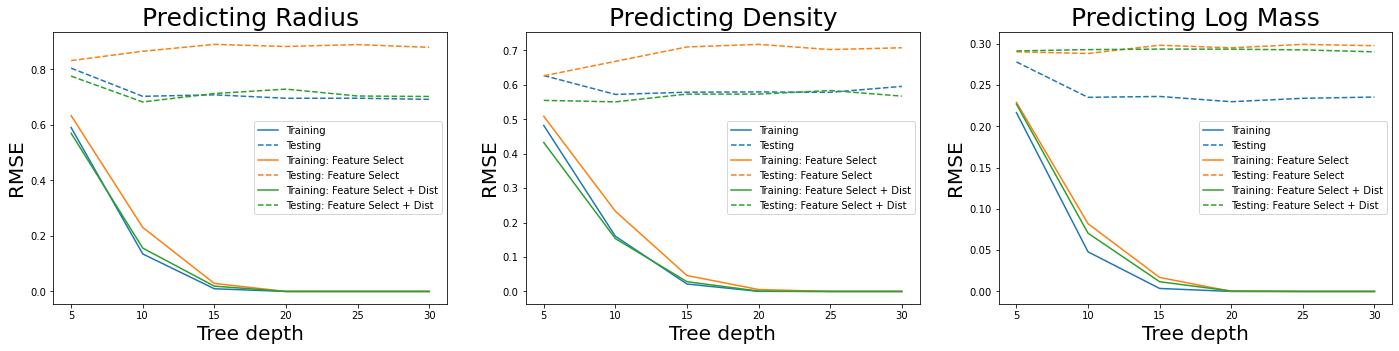

In [54]:
plt.figure(figsize=(24, 5))
for i in predict_idx:
    cols_in = cols[:i] + cols[i+1:]
    plt.subplot(1, 3, i+1)
    plt.plot(depths, train_vals_all[i], label='Training', c='tab:blue')
    plt.plot(depths, test_vals_all[i], label='Testing', c='tab:blue', linestyle='--')
    plt.plot(depths, train_vals_small[i], label='Training: Feature Select', c='tab:orange')
    plt.plot(depths, test_vals_small[i], label='Testing: Feature Select', c='tab:orange', linestyle='--')
    plt.plot(depths, train_vals_dist[i], label='Training: Feature Select + Dist', c='tab:green')
    plt.plot(depths, test_vals_dist[i], label='Testing: Feature Select + Dist', c='tab:green', linestyle='--')
    plt.title("Predicting {}".format(names[i]), fontsize=25)
    plt.ylabel("RMSE", fontsize=20)
    plt.xlabel("Tree depth", fontsize=20)
    plt.legend()
plt.show()

## From this we can see colour and S index dont do much so we can get rid of them in the classifier (and not predict mtype)

In [46]:
cols = ['tab:blue', 'tab:green', 'tab:red', 'tab:purple', 'tab:pink']
names = ["Fundamental Plane", "Radius", "Density", "Log Mass", "Mtype"]
data_raw = np.array([distances_all, radius[nan_mask_all], density[nan_mask_all], log_mass[nan_mask_all], mtype[nan_mask_all]]).T

data, data_holdout = train_test_split(data_raw, test_size=0.3, random_state=0)
data, data_holdout = list(data.T), list(data_holdout.T)

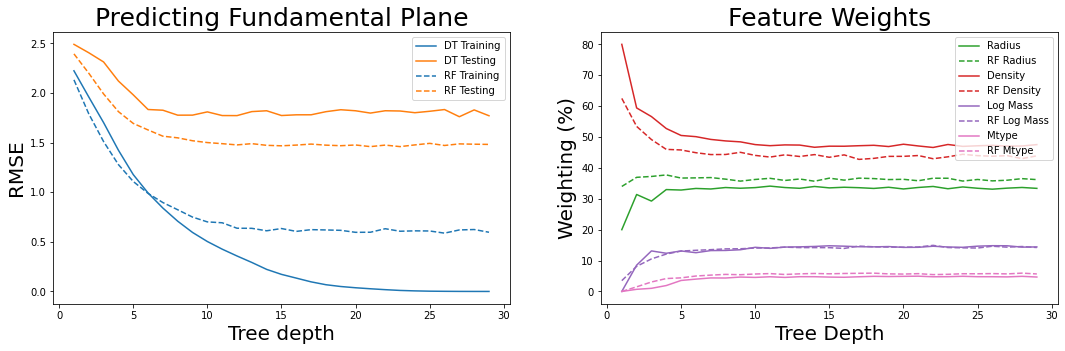

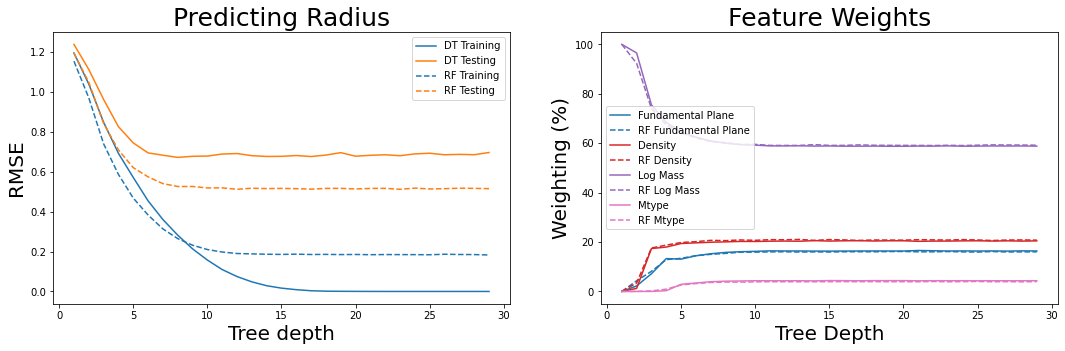

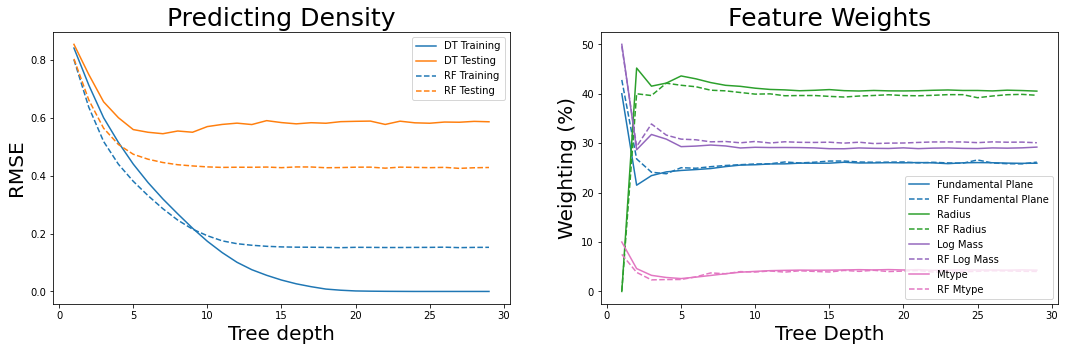

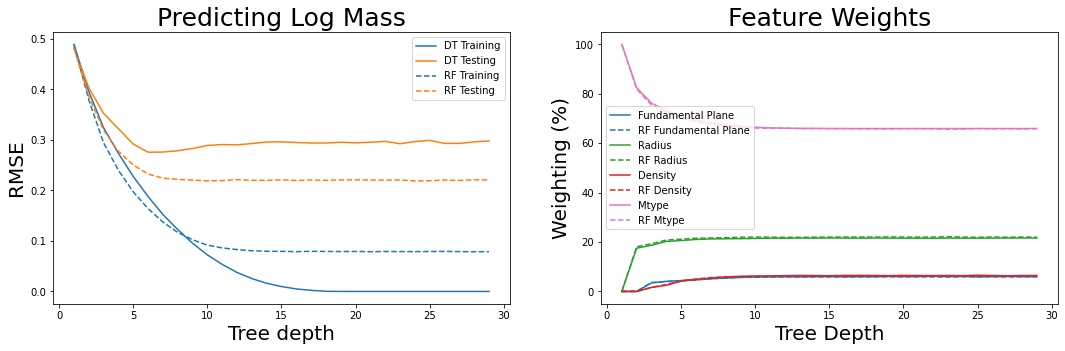

In [48]:
depths = np.arange(1, 30)
Ntest = 10
for i in range(len(data)):
    if i == 4:
        pass
    else:
        target = data[i]
        name = names[i]
        names_in = names[:i] + names[i+1:]
        data_in = np.array(data[:i] + data[i+1:]).T
        test_errs = np.zeros(depths.shape)
        train_errs = np.zeros(depths.shape)
        feature_vals = np.zeros([len(depths), len(names_in)])
        test_errs_RF = np.zeros(depths.shape)
        train_errs_RF = np.zeros(depths.shape)
        feature_vals_RF = np.zeros([len(depths), len(names_in)])

        for j in range(len(depths)):
                for k in range(Ntest):
                    X_train, X_test, Y_train, Y_test = train_test_split(data_in, target, test_size=0.25, random_state=k)
                    tree = DecisionTreeRegressor(max_depth=depths[j]).fit(X_train, Y_train)
                    RF = RandomForestRegressor(max_depth=depths[j]).fit(X_train, Y_train)
                    test_errs[j] += np.sqrt(mean_squared_error(Y_test, tree.predict(X_test)))/Ntest
                    train_errs[j] += np.sqrt(mean_squared_error(Y_train, tree.predict(X_train)))/Ntest
                    feature_vals[j] += (tree.feature_importances_*100)/Ntest
                    test_errs_RF[j] += np.sqrt(mean_squared_error(Y_test, RF.predict(X_test)))/Ntest
                    train_errs_RF[j] += np.sqrt(mean_squared_error(Y_train, RF.predict(X_train)))/Ntest
                    feature_vals_RF[j] += (RF.feature_importances_*100)/Ntest
        feature_vals = feature_vals.T
        feature_vals_RF = feature_vals_RF.T

        cols_in = cols[:i] + cols[i+1:]
        plt.figure(figsize=(18, 5))
        plt.subplot(1, 2, 1)
        plt.plot(depths, train_errs, label='DT Training', c='tab:blue')
        plt.plot(depths, test_errs, label='DT Testing', c='tab:orange')
        plt.plot(depths, train_errs_RF, label='RF Training', c='tab:blue', linestyle='--')
        plt.plot(depths, test_errs_RF, label='RF Testing', c='tab:orange', linestyle='--')
        plt.title("Predicting {}".format(names[i]), fontsize=25)
        plt.ylabel("RMSE", fontsize=20)
        plt.xlabel("Tree depth", fontsize=20)
        plt.legend()

        plt.subplot(1, 2, 2)
        for j in range(len(feature_vals)):
            plt.plot(depths, feature_vals[j], label=names_in[j], c=cols_in[j])
            plt.plot(depths, feature_vals_RF[j], label="RF {}".format(names_in[j]), c=cols_in[j], linestyle='--')
        plt.title("Feature Weights", fontsize=25)
        plt.ylabel("Weighting (%)", fontsize=20)
        plt.xlabel("Tree Depth", fontsize=20)
        plt.legend()

        plt.show()

In [57]:
cols = ['tab:green', 'tab:red', 'tab:purple', 'tab:pink']
names = ["Radius", "Density", "Log Mass", "Mtype"]
data_raw = np.array([radius[nan_mask_all], density[nan_mask_all], log_mass[nan_mask_all], mtype[nan_mask_all]]).T

data, data_holdout = train_test_split(data_raw, test_size=0.3, random_state=0)
data, data_holdout = list(data.T), list(data_holdout.T)

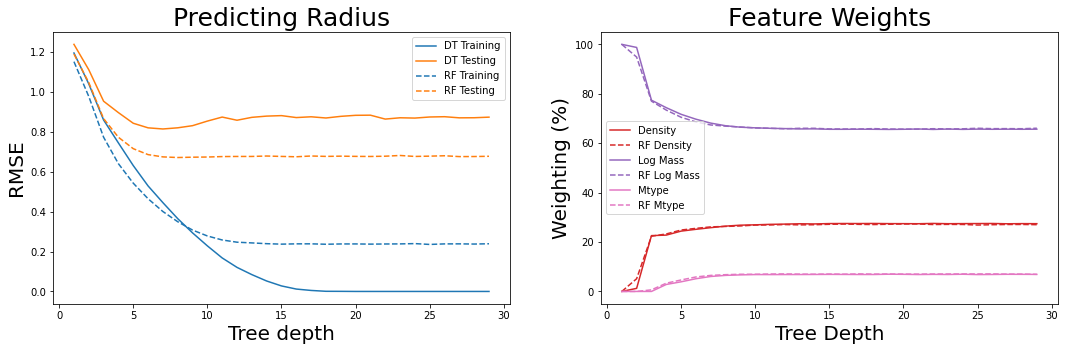

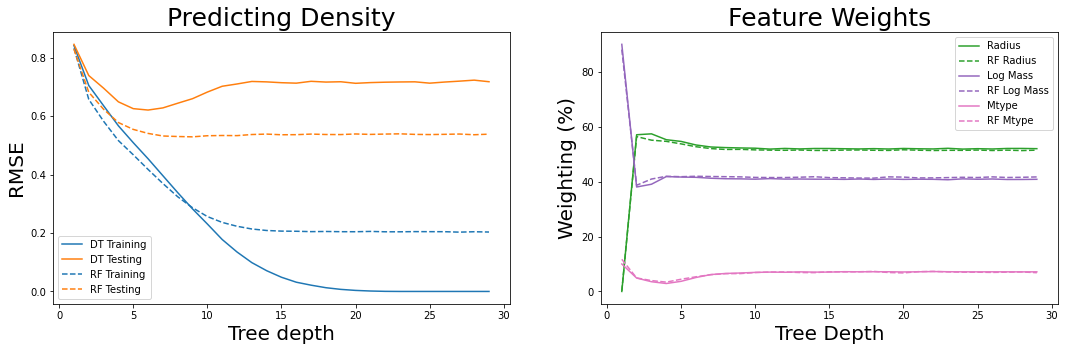

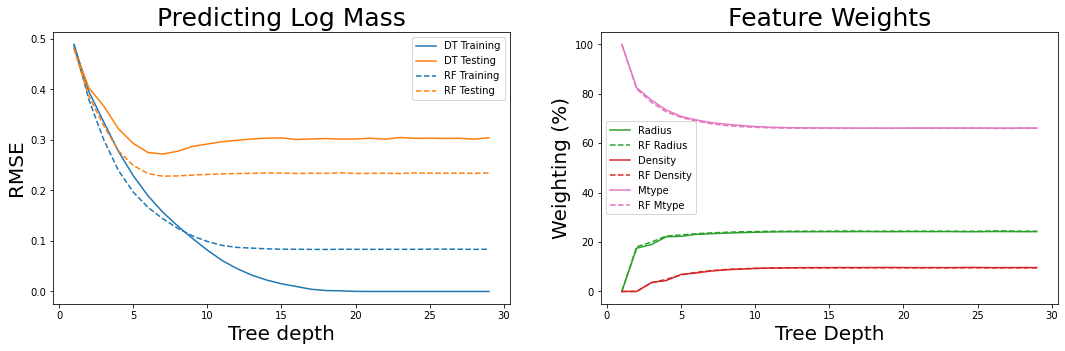

In [58]:
depths = np.arange(1, 30)
Ntest = 10
for i in range(len(data)):
    if i == 3:
        pass
    else:
        
        target = data[i]
        name = names[i]
        names_in = names[:i] + names[i+1:]
        data_in = np.array(data[:i] + data[i+1:]).T
        test_errs = np.zeros(depths.shape)
        train_errs = np.zeros(depths.shape)
        feature_vals = np.zeros([len(depths), len(names_in)])
        test_errs_RF = np.zeros(depths.shape)
        train_errs_RF = np.zeros(depths.shape)
        feature_vals_RF = np.zeros([len(depths), len(names_in)])

        for j in range(len(depths)):
                for k in range(Ntest):
                    X_train, X_test, Y_train, Y_test = train_test_split(data_in, target, test_size=0.25, random_state=k)
                    tree = DecisionTreeRegressor(max_depth=depths[j]).fit(X_train, Y_train)
                    RF = RandomForestRegressor(max_depth=depths[j]).fit(X_train, Y_train)
                    test_errs[j] += np.sqrt(mean_squared_error(Y_test, tree.predict(X_test)))/Ntest
                    train_errs[j] += np.sqrt(mean_squared_error(Y_train, tree.predict(X_train)))/Ntest
                    feature_vals[j] += (tree.feature_importances_*100)/Ntest
                    test_errs_RF[j] += np.sqrt(mean_squared_error(Y_test, RF.predict(X_test)))/Ntest
                    train_errs_RF[j] += np.sqrt(mean_squared_error(Y_train, RF.predict(X_train)))/Ntest
                    feature_vals_RF[j] += (RF.feature_importances_*100)/Ntest
        feature_vals = feature_vals.T
        feature_vals_RF = feature_vals_RF.T

        cols_in = cols[:i] + cols[i+1:]
        plt.figure(figsize=(18, 5))
        plt.subplot(1, 2, 1)
        plt.plot(depths, train_errs, label='DT Training', c='tab:blue')
        plt.plot(depths, test_errs, label='DT Testing', c='tab:orange')
        plt.plot(depths, train_errs_RF, label='RF Training', c='tab:blue', linestyle='--')
        plt.plot(depths, test_errs_RF, label='RF Testing', c='tab:orange', linestyle='--')
        plt.title("Predicting {}".format(names[i]), fontsize=25)
        plt.ylabel("RMSE", fontsize=20)
        plt.xlabel("Tree depth", fontsize=20)
        plt.legend()

        plt.subplot(1, 2, 2)
        for j in range(len(feature_vals)):
            plt.plot(depths, feature_vals[j], label=names_in[j], c=cols_in[j])
            plt.plot(depths, feature_vals_RF[j], label="RF {}".format(names_in[j]), c=cols_in[j], linestyle='--')
        plt.title("Feature Weights", fontsize=25)
        plt.ylabel("Weighting (%)", fontsize=20)
        plt.xlabel("Tree Depth", fontsize=20)
        plt.legend()

        plt.show()

## From this we select a tree depth of 10 as sufficient - Build the classifier (not predicting mtype)

In [53]:
parameters = {
    'criterion': ["mse", "mae"],
    'n_estimators': np.arange(10, 100, 10),
    'max_depth': np.arange(1, 31, 5)
             }

depths = np.arange(1, 30)
Ntest = 10
for i in range(len(data)):
    if i == 4:
        pass
    else:
        target = data[i]
        name = names[i]
        names_in = names[:i] + names[i+1:]
        data_in = np.array(data[:i] + data[i+1:]).T
        
        X_train, X_test, Y_train, Y_test = train_test_split(data_in, target, test_size=0.25, random_state=0)
        cv = GridSearchCV(RandomForestRegressor(), parameters).fit(X_train, Y_train)
        
        print(cv.best_params_)
#         print(scores)
        
#         test_errs = np.zeros(depths.shape)
#         train_errs = np.zeros(depths.shape)
#         feature_vals = np.zeros([len(depths), len(names_in)])
#         test_errs_RF = np.zeros(depths.shape)
#         train_errs_RF = np.zeros(depths.shape)
#         feature_vals_RF = np.zeros([len(depths), len(names_in)])

#         for j in range(len(depths)):
#                 for k in range(Ntest):
#                     
#                     tree = DecisionTreeRegressor(max_depth=depths[j]).fit(X_train, Y_train)
#                     RF = RandomForestRegressor(max_depth=depths[j]).fit(X_train, Y_train)
#                     test_errs[j] += np.sqrt(mean_squared_error(Y_test, tree.predict(X_test)))/Ntest
#                     train_errs[j] += np.sqrt(mean_squared_error(Y_train, tree.predict(X_train)))/Ntest
#                     feature_vals[j] += (tree.feature_importances_*100)/Ntest
#                     test_errs_RF[j] += np.sqrt(mean_squared_error(Y_test, RF.predict(X_test)))/Ntest
#                     train_errs_RF[j] += np.sqrt(mean_squared_error(Y_train, RF.predict(X_train)))/Ntest
#                     feature_vals_RF[j] += (RF.feature_importances_*100)/Ntest
#         feature_vals = feature_vals.T
#         feature_vals_RF = feature_vals_RF.T

#         cols_in = cols[:i] + cols[i+1:]
#         plt.figure(figsize=(18, 5))
#         plt.subplot(1, 2, 1)
#         plt.plot(depths, train_errs, label='DT Training', c='tab:blue')
#         plt.plot(depths, test_errs, label='DT Testing', c='tab:orange')
#         plt.plot(depths, train_errs_RF, label='RF Training', c='tab:blue', linestyle='--')
#         plt.plot(depths, test_errs_RF, label='RF Testing', c='tab:orange', linestyle='--')
#         plt.title("Predicting {}".format(names[i]), fontsize=25)
#         plt.ylabel("RMSE", fontsize=20)
#         plt.xlabel("Tree depth", fontsize=20)
#         plt.legend()

#         plt.subplot(1, 2, 2)
#         for j in range(len(feature_vals)):
#             plt.plot(depths, feature_vals[j], label=names_in[j], c=cols_in[j])
#             plt.plot(depths, feature_vals_RF[j], label="RF {}".format(names_in[j]), c=cols_in[j], linestyle='--')
#         plt.title("Feature Weights", fontsize=25)
#         plt.ylabel("Weighting (%)", fontsize=20)
#         plt.xlabel("Tree Depth", fontsize=20)
#         plt.legend()

#         plt.show()



{'criterion': 'mse', 'max_depth': 21, 'n_estimators': 50}
{'criterion': 'mse', 'max_depth': 16, 'n_estimators': 90}
{'criterion': 'mae', 'max_depth': 16, 'n_estimators': 80}
{'criterion': 'mae', 'max_depth': 26, 'n_estimators': 60}


In [54]:
crits = ['mse', 'mse', 'mae', 'mae']
depths = [21, 16, 16, 26]
n_est = [50, 90, 80, 60]

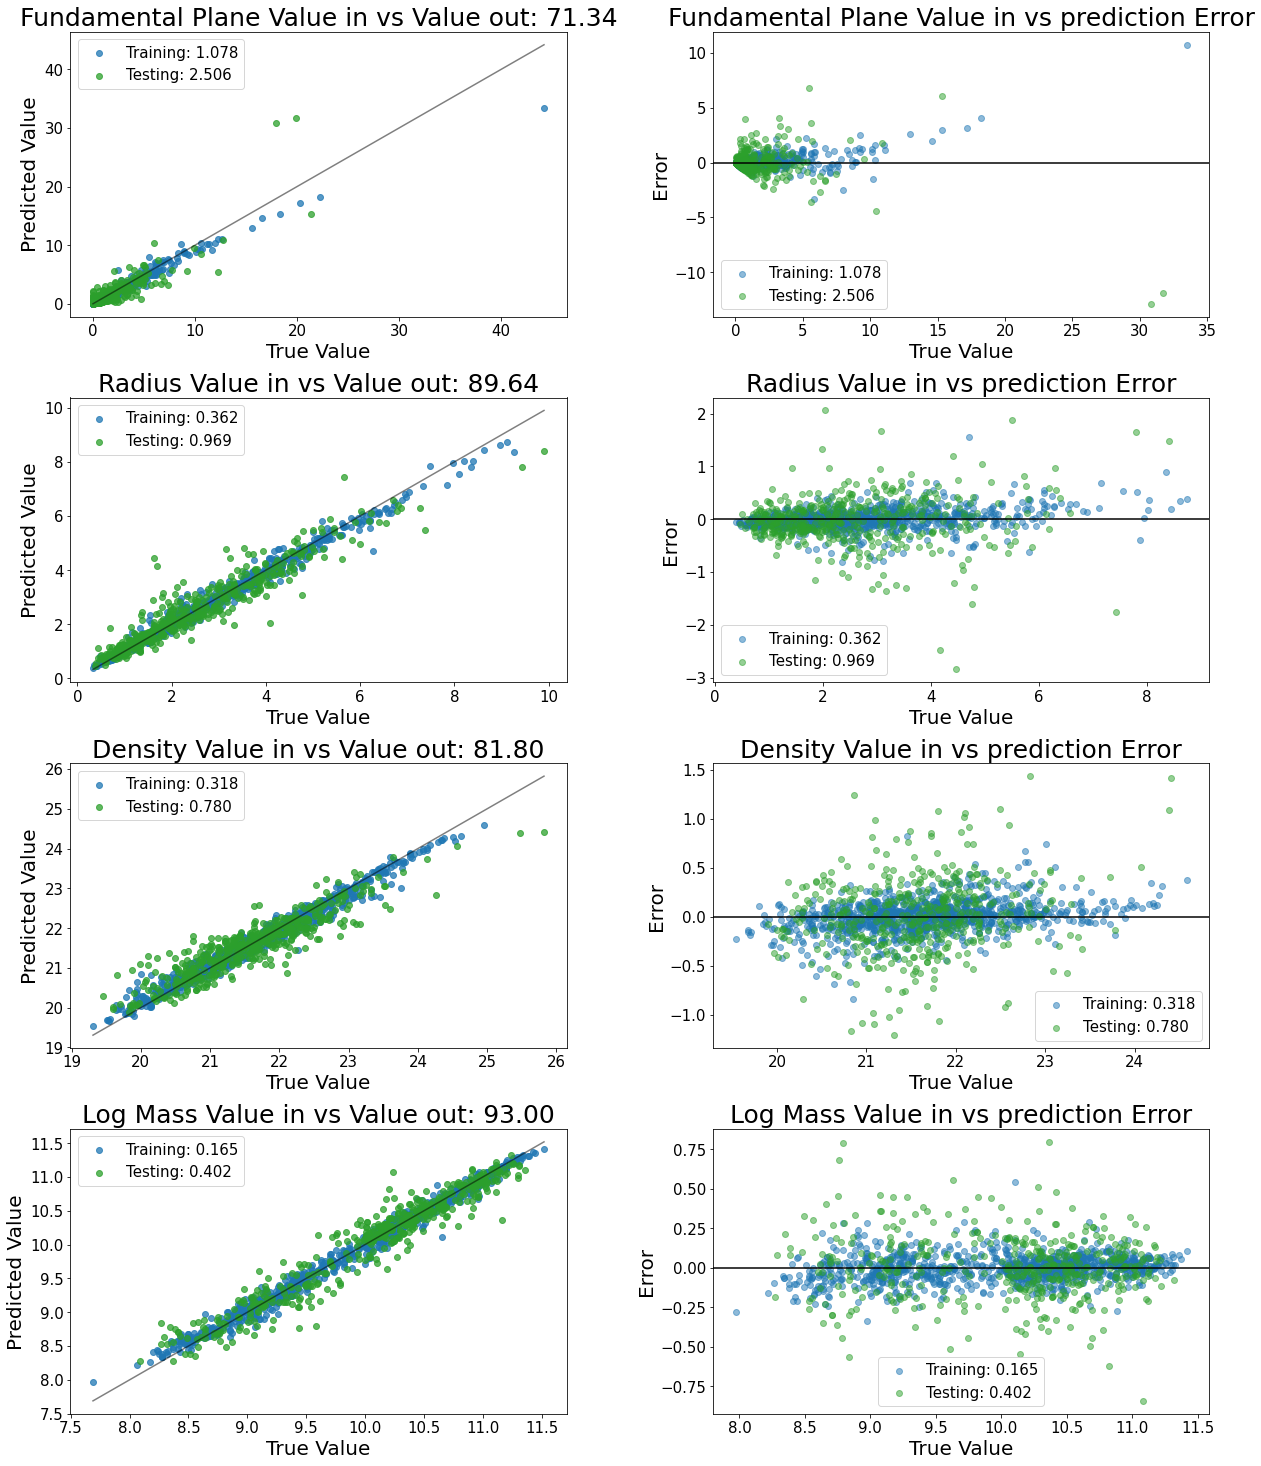

In [56]:
depth = 10
plt.figure(figsize=(18, 30))
idx = 1
ith = 0
for i in range(len(data)):
    if i == 4:
        pass
    else:
        name = names[i]
        names_in = names[:i] + names[i+1:]
        X_train = np.array(data[:i] + data[i+1:]).T
        Y_train = data[i]
        X_test = np.array(data_holdout[:i] + data_holdout[i+1:]).T
        Y_test = data_holdout[i]
#         tree = DecisionTreeRegressor(max_depth=depth).fit(X_train, Y_train)
        RF = RandomForestRegressor(max_depth=depths[ith], criterion=crits[ith], n_estimators=n_est[ith]).fit(X_train, Y_train)
        stderr_train = np.sqrt(mean_squared_error(Y_train, RF.predict(X_train)))
        stderr_test = np.sqrt(mean_squared_error(Y_test, RF.predict(X_test)))
#         Rsq = r2_score(Y_test, RF.predict(X_test))
#         xs = np.linspace(np.min(data_raw[:, i]), np.max(data_raw[:, i]))
        ith += 1
        
        plt.subplot(6, 2, idx)
        plt.scatter(Y_train, RF.predict(X_train), c='tab:blue', label="Training: {:.3f}".format(2*stderr_train), alpha=0.75)
        plt.scatter(Y_test, RF.predict(X_test), c='tab:green', label="Testing: {:.3f}".format(2*stderr_test), alpha=0.75)
        plt.title("{} Value in vs Value out: {:.2f}".format(names[i], 100*Rsq), fontsize=25)
        plt.ylabel("Predicted Value", fontsize=20)
        plt.xlabel("True Value", fontsize=20)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        xs = np.linspace(np.min(data_raw[:, i]), np.max(data_raw[:, i]))
        plt.plot(xs, xs, c='k', alpha=0.5)
        plt.legend(fontsize=15)

        plt.subplot(6, 2, idx+1)
        plt.scatter(RF.predict(X_train), Y_train - RF.predict(X_train), c='tab:blue', label="Training: {:.3f}".format(2*stderr_train), alpha=0.5)
        plt.scatter(RF.predict(X_test), Y_test - RF.predict(X_test), c='tab:green', label="Testing: {:.3f}".format(2*stderr_test), alpha=0.5)
        plt.title("{} Value in vs prediction Error".format(names[i]), fontsize=25)
        plt.ylabel("Error", fontsize=20)
        plt.xlabel("True Value", fontsize=20)
        plt.axhline(0, c='k')
        plt.legend(fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        
        idx += 2
        
plt.tight_layout()